## ProNet Video Object recognition - Vanilla dataset reference evaluation


Our notebook works now. OUr test set h owever is way too small. Skewing our results.
Make it so that each class is at least 15 images or so. tO DO THIS we shuld utilize the reference notebook help. Modify the preprocessing notebook to allow for the generation of train-test split properly.

For Shuffling = True Argument, see Keras BugThread
https://github.com/keras-team/keras/issues/6499

Caltech_15 vanilla : 48% 51% (40 finetune)

Caltech_10 vanilla: 56.5%   64.5%   (20 ft)


In [4]:

#TODO, Apply VGG19
#https://lihan.me/2018/01/vgg19-caltech101-classification/


# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
#set randomness for reproducibility
from numpy.random import seed
seed(8) #1
from tensorflow import set_random_seed
set_random_seed(7) #2

#

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os



#Download the training dataset- Caltech101 Vanilla (unprocessed)
#!gdown https://drive.google.com/uc?id=1M102b38u9aptwFiLQJYu3n3_7sYbCB4y
#!unzip Caltech_separated.zip

#Caltech vanilla (unprocessed) with 15 test images

#!gdown https://drive.google.com/uc?id=153e-lZfM92q4PZMpDvdtJou4iSOwkft4
#!unzip CaltechDataset_separated_15.zip

#Caltech vanilla (unprocessed) with 10 test images

!gdown https://drive.google.com/uc?id=1LhyI2F0k3PbFo4A6YQ9HEg5pQera2NoF
!unzip CaltechDataset_separated_10.zip



Streaming output truncated to the last 5000 lines.
  inflating: CaltechDataset/Caltech101/grand_piano/image_0063.jpg  
  inflating: CaltechDataset/Caltech101/grand_piano/image_0064.jpg  
  inflating: CaltechDataset/Caltech101/grand_piano/image_0065.jpg  
  inflating: CaltechDataset/Caltech101/grand_piano/image_0066.jpg  
  inflating: CaltechDataset/Caltech101/grand_piano/image_0067.jpg  
  inflating: CaltechDataset/Caltech101/grand_piano/image_0068.jpg  
  inflating: CaltechDataset/Caltech101/grand_piano/image_0069.jpg  
  inflating: CaltechDataset/Caltech101/grand_piano/image_0070.jpg  
  inflating: CaltechDataset/Caltech101/grand_piano/image_0071.jpg  
  inflating: CaltechDataset/Caltech101/grand_piano/image_0072.jpg  
  inflating: CaltechDataset/Caltech101/grand_piano/image_0074.jpg  
  inflating: CaltechDataset/Caltech101/grand_piano/image_0075.jpg  
  inflating: CaltechDataset/Caltech101/grand_piano/image_0076.jpg  
  inflating: CaltechDataset/Caltech101/grand_piano/image_0077.jpg

In [5]:
print(os.listdir("/content/"))

#Print and remove zips once done

!rm CaltechDataset_separated_10.zip



['.config', 'open?id=1LhyI2F0k3PbFo4A6YQ9HEg5pQera2NoF', 'CaltechDataset', 'CaltechDataset_separated_10.zip', 'sample_data']
rm: cannot remove 'CaltechDataset_separated_15.zip': No such file or directory


In [6]:
from os import listdir
data_list = listdir('/content/CaltechDataset/Caltech101')

#Delete some classes that may interfere


data_list

['schooner',
 'elephant',
 'crocodile',
 'pigeon',
 'kangaroo',
 'pagoda',
 'rhino',
 'euphonium',
 'brain',
 'llama',
 'sunflower',
 'starfish',
 'Faces_easy',
 'sea_horse',
 'crocodile_head',
 'garfield',
 'binocular',
 'dollar_bill',
 'panda',
 'mayfly',
 'hedgehog',
 'cannon',
 'menorah',
 'platypus',
 'revolver',
 'pizza',
 'BACKGROUND_Google',
 'mandolin',
 'rooster',
 'barrel',
 'camera',
 'Faces',
 'watch',
 'ant',
 'umbrella',
 'laptop',
 'water_lilly',
 'saxophone',
 'trilobite',
 'Leopards',
 'cellphone',
 'stop_sign',
 'accordion',
 'snoopy',
 'pyramid',
 'headphone',
 'bonsai',
 'cougar_body',
 'gerenuk',
 'chandelier',
 'stegosaurus',
 'dragonfly',
 'wrench',
 'grand_piano',
 'dalmatian',
 'lobster',
 'nautilus',
 'cup',
 'car_side',
 'lotus',
 'chair',
 'Motorbikes',
 'yin_yang',
 'cougar_face',
 'soccer_ball',
 'flamingo',
 'ketch',
 'airplanes',
 'dolphin',
 'ibis',
 'wild_cat',
 'emu',
 'windsor_chair',
 'flamingo_head',
 'bass',
 'okapi',
 'buddha',
 'hawksbill',
 'e

Resnet Initialization

In [7]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model ,load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import tensorflow as tf


DATASET_PATH  = '/content/CaltechDataset/Caltech101'
test_dir =  '/content/CaltechDataset/test'
IMAGE_SIZE    = (150, 150)
NUM_CLASSES   = len(data_list)
BATCH_SIZE    = 25  # try reducing batch size or freeze more layers if your GPU runs out of memory
FREEZE_LAYERS = 25  # freeze the first this many layers for training
NUM_EPOCHS    = 40
LEARNING_RATE =0.0002 #start off with high rate first 0.001 #5e-4
#5e-5 #Slow learn rate as we are transfer training
DROP_OUT = .5



#Train datagen here is a preprocessor
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=50,
                                   featurewise_center = True,
                                   featurewise_std_normalization = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.25,
                                   zoom_range=0.1,
                                   zca_whitening = True,
                                   channel_shift_range = 20,
                                   horizontal_flip = True ,
                                   vertical_flip = True ,
                                   validation_split = 0.2,
                                   fill_mode='constant')

# test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
#                                    fill_mode='constant')

train_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "training",
                                                  seed=42,
                                                  class_mode="categorical"
                                                  )

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,
                                                  class_mode="categorical"
                                                 
                                                  )

#MAKE A TEST DATAGEN linking to separate path
#train_batches


#why is this 102 classes???

#https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 6540 images belonging to 102 classes.
Found 1584 images belonging to 102 classes.


Layer Modification at upper layer of Resnet

In [8]:
#Simple CNN model based on


from keras import models
from keras import layers
from keras.applications import VGG16
from keras import optimizers

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))


conv_base.trainable = False


model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(102, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['acc'])





58892288/58889256 [==============================] - 1s 0us/step










In [9]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 102)               26214     
Total params: 16,838,310
Trainable params: 2,123,622
Non-trainable params: 14,714,688
_________________________________________________________________
None


Training

In [10]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

result=model.fit_generator(train_batches,
                        steps_per_epoch =STEP_SIZE_TRAIN,
                        validation_data = valid_batches,
                        validation_steps = STEP_SIZE_VALID,
                        epochs= NUM_EPOCHS,
#                         
                       )



262
64
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/40


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


261/261 [==============================] - 60s 230ms/step - loss: 3.0190 - acc: 0.3689 - val_loss: 2.4212 - val_acc: 0.4629
Epoch 2/40
261/261 [==============================] - 56s 215ms/step - loss: 2.0669 - acc: 0.5302 - val_loss: 1.8524 - val_acc: 0.5619
Epoch 3/40
261/261 [==============================] - 56s 214ms/step - loss: 1.6636 - acc: 0.5991 - val_loss: 1.6181 - val_acc: 0.6087
Epoch 4/40
261/261 [==============================] - 56s 214ms/step - loss: 1.4609 - acc: 0.6353 - val_loss: 1.4873 - val_acc: 0.6369
Epoch 5/40
261/261 [==============================] - 56s 214ms/step - loss: 1.3397 - acc: 0.6590 - val_loss: 1.3778 - val_acc: 0.6466
Epoch 6/40
261/261 [==============================] - 56s 213ms/step - loss: 1.2364 - acc: 0.6798 - val_loss: 1.3909 - val_acc: 0.6414
Epoch 7/40
261/261 [==============================] - 56s 214ms/step - loss: 1.1469 - acc: 0.7052 - val_loss: 1.2651 - val_acc: 0.6921
Epoch 8/40
261/261 [==============================] - 56s 213ms/st

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


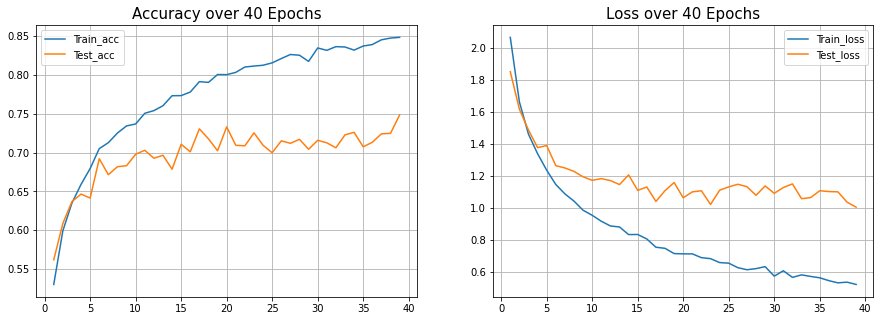

In [11]:
import matplotlib.pyplot as plt


def plot_acc_loss(result, epochs):
    acc = result.history['acc']
    loss = result.history['loss']
    val_acc = result.history['val_acc']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Test_acc')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Test_loss')
    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_acc_loss(result, 40)

In [12]:
model.save('vanilla_model_100epochs_0pt001.h5')

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Predict

In [13]:

#Dont forget shuffle false
#See https://github.com/keras-team/keras/issues/6499
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(
        test_dir,target_size=IMAGE_SIZE,
        batch_size=1,
        shuffle=True,
        seed=42,
        
        class_mode="categorical")
eval_generator.reset()    


Found 1020 images belonging to 102 classes.


In [14]:

eval_generator.reset()  
x = model.evaluate_generator(eval_generator,
                           steps = np.ceil(len(eval_generator) / BATCH_SIZE),
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1
                           )


print('Test loss:' , x[0])
print('Test accuracy:',x[1])

#Poor test accuracy due to the small dataset size

41/41 [==============================] - 0s 10ms/step
Test loss: 1.425130282667829
Test accuracy: 0.6829268292682927


Save

In [15]:
#Save results
"""
filenames=eval_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("ProNet_CNN_100epochs_0pt0005take2_RandomProcess.csv",index=False)
"""

'\nfilenames=eval_generator.filenames\nresults=pd.DataFrame({"Filename":filenames,\n                      "Predictions":predictions})\nresults.to_csv("ProNet_CNN_100epochs_0pt0005take2_RandomProcess.csv",index=False)\n'

Epoch 1/20


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


261/261 [==============================] - 57s 219ms/step - loss: 0.4625 - acc: 0.8647 - val_loss: 1.0177 - val_acc: 0.7435
Epoch 2/20
261/261 [==============================] - 57s 219ms/step - loss: 0.4526 - acc: 0.8702 - val_loss: 1.0578 - val_acc: 0.7158
Epoch 3/20
261/261 [==============================] - 57s 219ms/step - loss: 0.4435 - acc: 0.8713 - val_loss: 0.9948 - val_acc: 0.7505
Epoch 4/20
261/261 [==============================] - 57s 218ms/step - loss: 0.4376 - acc: 0.8739 - val_loss: 1.0101 - val_acc: 0.7409
Epoch 5/20
261/261 [==============================] - 57s 217ms/step - loss: 0.4445 - acc: 0.8742 - val_loss: 1.0241 - val_acc: 0.7409
Epoch 6/20
261/261 [==============================] - 57s 217ms/step - loss: 0.4305 - acc: 0.8789 - val_loss: 0.9329 - val_acc: 0.7556
Epoch 7/20
261/261 [==============================] - 57s 219ms/step - loss: 0.4386 - acc: 0.8723 - val_loss: 1.0380 - val_acc: 0.7453
Epoch 8/20
261/261 [==============================] - 58s 222ms/st

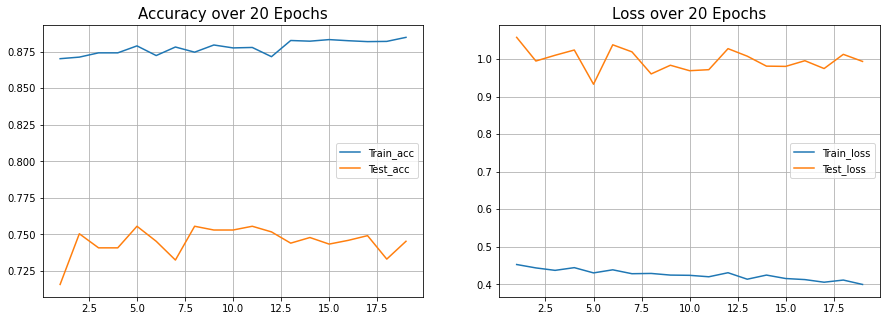

41/41 [==============================] - 0s 7ms/step
Test loss: 1.3798199310223005
Test accuracy: 0.6829268292682927


In [16]:
#Continue finetune


model.compile(loss='categorical_crossentropy',
              
              optimizer=optimizers.Adam(lr=5e-5),
              metrics=['acc'])

result=model.fit_generator(train_batches,
                        steps_per_epoch =STEP_SIZE_TRAIN,
                        validation_data = valid_batches,
                        validation_steps = STEP_SIZE_VALID,
                        epochs= 20,
                       
                       )

plot_acc_loss(result, 20)

eval_generator.reset()  
x = model.evaluate_generator(eval_generator,
                           steps = np.ceil(len(eval_generator) / BATCH_SIZE),
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1
                           )


print('Test loss:' , x[0])
print('Test accuracy:',x[1])





In [17]:
eval_generator = test_datagen.flow_from_directory(
        test_dir,target_size=IMAGE_SIZE,
        batch_size=1,
        shuffle=True,
        seed=42,
        
        class_mode="categorical")
eval_generator.reset()  


x = model.evaluate_generator(eval_generator,
                           steps = np.ceil(len(eval_generator) / BATCH_SIZE),
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1
                           )


print('Test loss:' , x[0])
print('Test accuracy:',x[1])


Found 1020 images belonging to 102 classes.
41/41 [==============================] - 0s 6ms/step
Test loss: 1.3798199310223005
Test accuracy: 0.6829268292682927
